# <font color='darkblue'> THE NETWORK OF BEATLES' SONGS

## <font color='darkblue'>Analysis of the network of Beatles'Songs: Getting into their mind

In [1]:
#We import all the necessary packages we used for this project

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import ast
import operator
import powerlaw
from fa2 import ForceAtlas2
import re
from urllib.request import urlopen
import urllib.request as urllib2
import os
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import community.community_louvain
import matplotlib.cm as cm

###  <font color='darkblue'>Part 1a: Extraction of information from Beatles Official Page.

In [2]:
#We have create a function to obtain the 'HTLM' of Beatles Official Page. 
def extract_html(url):
    page = urlopen(url)
    html_bytes = page.read()
    html = html_bytes.decode("utf-8")
    return html

In [48]:
#We obtain all the list of songs and we stored it in the Variable Songs_Titles
pattern1= 'hreflang="en">(.*?)</a>'
pattern2= 'chronological-date">(.*?)</td>'

songs_titles=[]
song_years=[]

for i in range(0,9): 
    url = 'https://www.thebeatles.com/songs?page='+str(i)
    html=extract_html(url)
    a=re.findall(pattern1,html)
    b=re.findall(pattern2,html)
    
    for el in a:
        el=el.replace('&#039;', '\'')
        songs_titles.append(el)
    
    for el2 in b:
        song_years.append(el2)

print('The official Beatles page contains information of a number of' , len(songs_titles), 'songs.')

The official Beatles page contains information of a number of 301 songs.


In [4]:
data00={'Song':songs_titles,'Year':song_years}
data0=pd.DataFrame(data00)

<font color='darkblue'>Below, we extract the release data of the song in terms of **day, month and year.**

In [5]:
years=[]
months=[]
days=[]

for date in data0['Year']:
    date=date.split(' ')
    years.append(date[3])
    months.append(date[2][:-1])
    days.append(date[1][:-2])

data11={'Song':songs_titles,'Year':years,'Month':months,'Day':days}
data_df=pd.DataFrame(data11)
data_df

,Song,Year,Month,Day
0,12-Bar Original,1996,March,18
1,1822!,1994,November,30
2,A Beginning,1996,October,28
3,A Day In The Life,1967,June,1
4,A Hard Day's Night,1964,July,10
...,...,...,...,...
296,You'll Be Mine,1995,November,20
297,You're Going To Lose That Girl,1965,August,6
298,You've Got To Hide Your Love Away,1965,August,6
299,Young Blood,1994,November,30


In [97]:
months_value={'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,
             'July':7,'August':8,'September':9,'October':10,'November':11,'December':12}

months_sorted=data_df.replace({'Month': months_value}).sort_values(by=['Year','Month','Day']).index
data_df=data_df.reindex(months_sorted)
data_df=data_df.reset_index(drop=True)
data_df

,Song,Year,Month,Day
0,Love Me Do,1962,October,5
1,P.S. I Love You,1962,October,5
2,Ask Me Why,1963,January,11
3,Please Please Me,1963,January,11
4,A Taste Of Honey,1963,March,22
...,...,...,...,...
296,You Know My Name,2012,December,14
297,You Like Me Too Much,2012,December,14
298,Sie Liebt Dich,2013,February,7
299,Slow Down,2013,February,7


In [51]:
remove_list=[' a ',' in ',' the ',' of ',' to ',' is ',' at ',' for ',' that ',' by ',' as ',' from ',' into ',
             ' on ',' with ',' off ',' this ',' up ',' like ']
remove_list_start=['a-','in-','the-','of-','to-','is-','at-','for-','that-','by-','as-','from-','like-','this-',
                  'with-']
remove_list_end=['-by','-to','-on','-is','-that','-before']
remove_list2=['\'','.','!','(',')',',','/',':']

pattern6='<div class="col-md-6 middle-content border-left border-right"><p>'
pattern7='<figure class="wp-block-table table-expander table table-imported">'

songs_titles2=[]
for title in songs_titles:
    try:
        title=title.lower()
        for el in remove_list2: # delete special characters
            title=title.replace(el,'')
        for el in remove_list: # replace single words with a space
            title=title.replace(el,' ')
        title=title.replace(' ','-')
        title=title.replace('--','-')
        # delete words from the start
        for i in range(0,6):
            if title[:i] in remove_list_start:
                title=title[i:]
        # delete words end
        for i in range(0,8):
            if title[-i:] in remove_list_end:
                title=title[:-i]
        if title[0]=='-':
            title=title[1:]
        url='https://www.thebeatles.com/'
        query=extract_html(url+title)
        # write the extracted text in a .txt file
        file=open('raw_songs/'+title+'.txt','w+')
        file.write(query)
        file.close()
        songs_titles2.append(title)
    except:
        print(title) #To know the songs where the url could not be obtained. 
        

words-love


<font color='darkblue'>Sometimes, the page of the song has a number at the end, being a 0 or 1. This is the case of words-love-0. 

In [8]:
pattern6='<div class="col-md-6 middle-content border-left border-right"><p>'
pattern7='<figure class="wp-block-table table-expander table table-imported">'
remove_list=['<br />','\n','</p>','<p>']

def extract_lyrics(song_path):
    song=open(song_path).read()
    idx_init = re.search(pattern6,song).end()
    idx_final = re.search(pattern7,song).start()
    lyrics=song[idx_init:idx_final]
    for el in remove_list: # delete special characters
        lyrics=lyrics.replace(el,' ')
    return lyrics

<font color='darkblue'>Then, we extract the lyrics of each songs specifying the patterns. Provided that the song has no lyrics, we classified it as an instrumental song and will not be part of our network. 

In [9]:
txt_files = os.listdir('raw_songs')
songs_no_lyrics=[]
for el in txt_files:
    el=el[:-4]
    song_path='raw_songs/'+el+'.txt'
    try:
        lyrics=extract_lyrics(song_path)
        file=open('lyrics_songs/'+el+'.txt','w+')
        file.write(lyrics)
        file.close()
    except:
        songs_no_lyrics.append(el)


In [11]:
lyrics_files = os.listdir('lyrics_songs')
for el in songs_no_lyrics:
    el=el[:-4]
    url='https://www.thebeatles.com/'
    # check if the song has lyrics or not
    for i in range(0,4):
        try:
            query=extract_html(url+el+'-'+str(i))
            idx_init = re.search(pattern6,query).end()
            idx_final = re.search(pattern7,query).start()
            # rewrite the extracted text in a .txt file
            file=open('raw_songs/'+el+'.txt','w+')
            file.write(query)
            file.close()
            print(el, i)
            break
        except:
            pass


In [12]:
print('The official Beatles page contains' , len(lyrics_files)+len(songs_no_lyrics), 'Songs, with',len(lyrics_files),
     'Lyrics Songs and',len(songs_no_lyrics),'Instrumental ones. ') 

The official Beatles page contains 302 Songs, with 198 Lyrics Songs and 104 Instrumental ones. 


###  <font color='darkblue'>Part 1b: Extraction of information from Beatles Wikipages of Songs.

###  <font color='darkblue'>Part 2: Clean Lyrics of Songs.

In [13]:
stop_words = list(set(stopwords.words('english')))
stop_words = [el.replace('\'','') for el in stop_words]
stop_words.append('im')

<font color='darkblue'> A function to **clean the lyrics** is built.

In [14]:
def clean_lyrics(file_path):
    data=open(file_path).read()
    # import WordPunctTokenizer() method from nltk
    # Create a reference variable for Class WordPunctTokenizer
    tk = WordPunctTokenizer()
    # define punctuation
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    # remove punctuation from the string
    no_punct = ""
    for char in data:
        if char not in punctuations:
            no_punct = no_punct + char
    # Remove all the special characters as \n and single = left
    char=['\n','=']
    for el in char:
        raw=re.sub(el,'',no_punct)
    # remove stop words
    token_txt = tk.tokenize(raw.lower()) # set to lower case
    token_txt = tk.tokenize(raw.lower()) # set to lower case
    token_final = [x for x in token_txt if x not in stop_words and len(x)>2]
    return token_final

In [15]:
lyrics_files=[el[:-4] for el in os.listdir('lyrics_songs')]
lyrics_files.remove('.DS_S') # remove this element that is introduced when using os.listdir

###  <font color='darkblue'>Part 3: Build the Network.

In [16]:
#After cleaning the lyrics of songs, we found the first five most common words in each song. 
#d_top5 is a dictionary with the most common words used for each song. 
d_top5={}
for file in lyrics_files:
    path='lyrics_songs/'+file+'.txt'
    clean=clean_lyrics(path)
    
    top5=[]
    for el in FreqDist(clean).most_common(5):
        top5.append(el[0])
    d_top5[file]=top5
    

In [99]:
subs={}
for a,b in enumerate(songs_titles2):
    subs[songs_titles[a]]=b

data_df2=data_df.replace({'Song': subs})
data_df2

,Song,Year,Month,Day
0,love-me-do,1962,October,5
1,ps-i-love-you,1962,October,5
2,ask-me-why,1963,January,11
3,please-please-me,1963,January,11
4,taste-honey,1963,March,22
...,...,...,...,...
296,you-know-what-do,2012,December,14
297,you-never-give-me-your-money,2012,December,14
298,sie-liebt-dich,2013,February,7
299,slow-down,2013,February,7


In [105]:
hyperlinks={} #dictionary to store links 

for file1 in lyrics_files:
    eq_files=[]
    for file2 in lyrics_files:
        if file1!=file2:
            a=d_top5[file1]
            b=d_top5[file2]
            # compute if there are equal words in both lists
            eq=0
            
            for el in a:
                if el in b:
                    eq+=1
            if eq!=0:
                eq_files.append(file2)
                
    idx1=data_df2[data_df2['Song']==file1].index[0]

    eq_files_later=[]

    for eq in eq_files:
        idx2=data_df2[data_df2['Song']==eq].index[0]
        if idx1<idx2: # means that file1 song was released earlier
            eq_files_later.append(eq)
            
    hyperlinks[file1]=eq_files_later


<font color='darkblue'> With the links stored, we are able to build the directed Graph based on the date release of the corresponding songs. 

In [108]:
#We build the Directed Network
Beatles_nw= nx.DiGraph()
for file in lyrics_files:
    #We add the nodes and attributes to the the network
    file=file.replace('-',' ')
    Beatles_nw.add_node(file)

#We add the hyperlinks to the the network
for el in lyrics_files:
    links= hyperlinks[el]
    for a in links:
        u= el
        v= a
        u=u.replace('-',' ')
        v=v.replace('-',' ')
        Beatles_nw.add_edge(u,v)

<font color='darkblue'> Next, we extract the **GCC** subgraph of the Beatles network.

In [109]:
Gs = list(Beatles_nw.subgraph(c).copy() for c in nx.weakly_connected_components(Beatles_nw))
biggest = 0
GCC_index = 0
for index,graph in enumerate(Gs):
    if len(graph.nodes) > biggest:
        biggest = len(graph.nodes)
        GCC_index = index
GCC = Gs[GCC_index]

In [110]:
print('- Considering the GCC of the Beatles Network, it has',len(GCC.nodes()),'number of nodes and',
      len(GCC.edges.data()),'number of links.')

- Considering the GCC of the Beatles Network, it has 195 number of nodes and 2619 number of links.


###  <font color='darkblue'>Part 4: Visualize the Network.

In [130]:
# Determing node size depending on the degree of each node. 
degree=[el *15 for el in list(dict(GCC.out_degree()).values())]


#Specifying Labels
highest_degree = dict(sorted(GCC.out_degree, key=lambda x: x[1], reverse=True)[0:20])
labels_draw = list(highest_degree.keys())
labels = {}    
for node in GCC.nodes():
    if node in labels_draw:
        labels[node] = node


In [137]:
#Get node positions based on the Force Atlas 2 algorithm 
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.5,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.01,#1 before - 0.01 after
                        strongGravityMode=False,#False  before - true after
                        gravity=10, #1.0 before -1.5 after

                        # Log
                        verbose=False) #True before - false after

#getting node positions
positions = forceatlas2.forceatlas2_networkx_layout(GCC, pos=None, iterations=300)



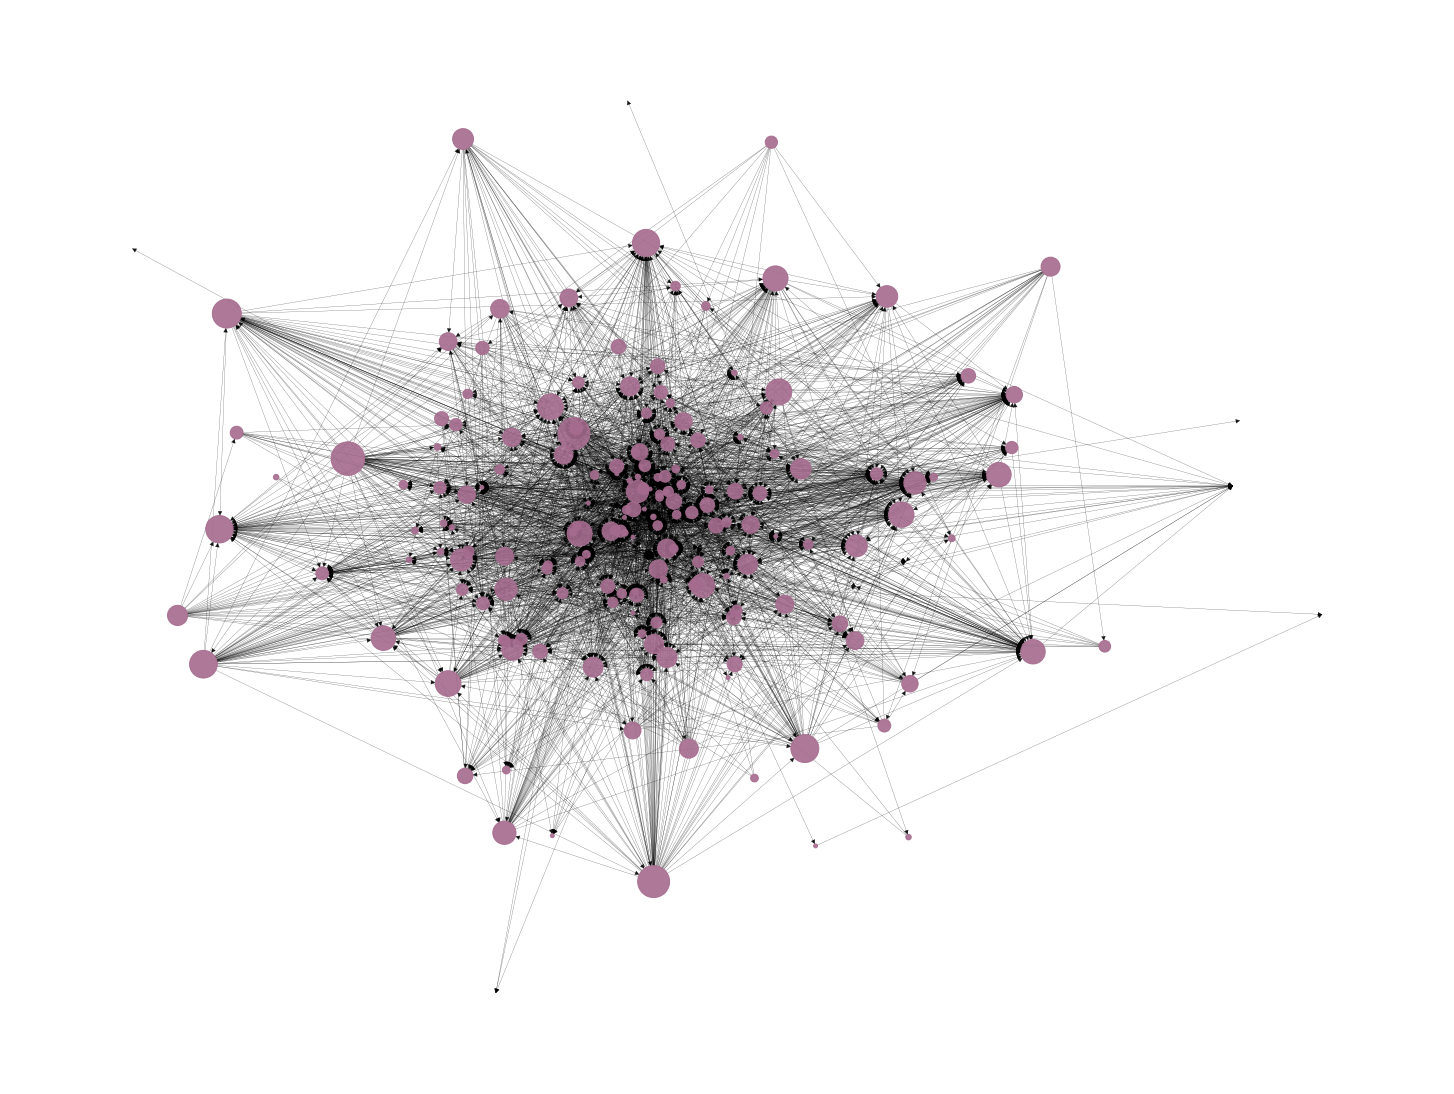

In [142]:
#VISUALIZATION
options = {
    'node_size': degree,
    'width': 0.2,
    #'edge_color':edge_colors,
    'node_color': '#a56b8e',
    #'labels':labels,
    'alpha':0.9
}

fig = plt.gcf()
nx.draw(GCC, positions,**options) 
fig.set_size_inches(20, 15)
plt.savefig("Final_Graph.png")


####  <font color='darkblue'>Part 4.1: Create a Network Evolution by Time.

In [143]:
#Code for Network Evolution 

####  <font color='darkblue'>Part 4.2: Statistical Analysis of the Network: In-degree and Out-degree Distributions. 

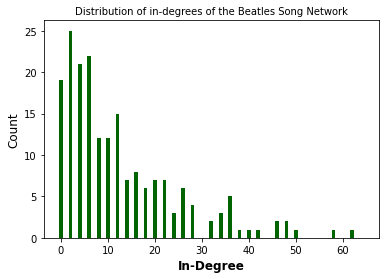

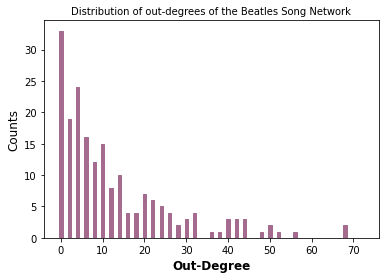

In [114]:
#Bar plot of the in-degree distribution
in_degrees = sorted(GCC.in_degree(GCC.nodes, weight=None), key=lambda x: x[1], reverse = True)
in_degrees_dist = [tuples[1] for tuples in in_degrees]
v1 = np.arange(int(min(in_degrees_dist )),int(max(in_degrees_dist)),2)

count1,bins1=np.histogram(in_degrees_dist ,bins=v1)
plt.bar(bins1[:-1], count1,color='darkgreen')
plt.title('Distribution of in-degrees of the Beatles Song Network',fontsize=10)
plt.xlabel('In-Degree',fontsize=12,fontweight='bold')
plt.ylabel('Count',fontsize=12)
plt.show() 

#Bar plot of the out-degree distribution
out_degrees = sorted(GCC.out_degree(GCC.nodes, weight=None), key=lambda x: x[1], reverse = True)
out_degrees_dist = [tuples[1] for tuples in out_degrees]

v2 = np.arange(int(min(out_degrees_dist)),int(max(out_degrees_dist)),2)
count2,bins2=np.histogram(out_degrees_dist,bins=v2)
plt.bar(bins2[:-1], count2,color='#a56b8e', edgecolor ='#a56b8e')
plt.title('Distribution of out-degrees of the Beatles Song Network',fontsize=10)
plt.xlabel('Out-Degree',fontsize=12,fontweight='bold')
plt.ylabel('Counts',fontsize=12)
plt.show() 



###  <font color='darkblue'>Part 5: Find Communities

In [115]:
# Compute the best partition. We need to take into account the undirected graph. 
un_Beatles_nw= GCC.to_undirected()
partition = community.community_louvain.best_partition(un_Beatles_nw)

print('Number of communities found: ', len(np.unique(list(partition.values()))))

Number of communities found:  5


In [116]:
mod = community.community_louvain.modularity(partition, un_Beatles_nw)
print("The modularity value is:","{:.3f}".format(mod))

The modularity value is: 0.324


####  <font color='darkblue'>Visualize Communities:

In [117]:
node_community = [node[1] for node in partition.items()]
pCol = {i: list(np.random.random(size=3)) for i in set(node_community)}


The distribution of the community sizes


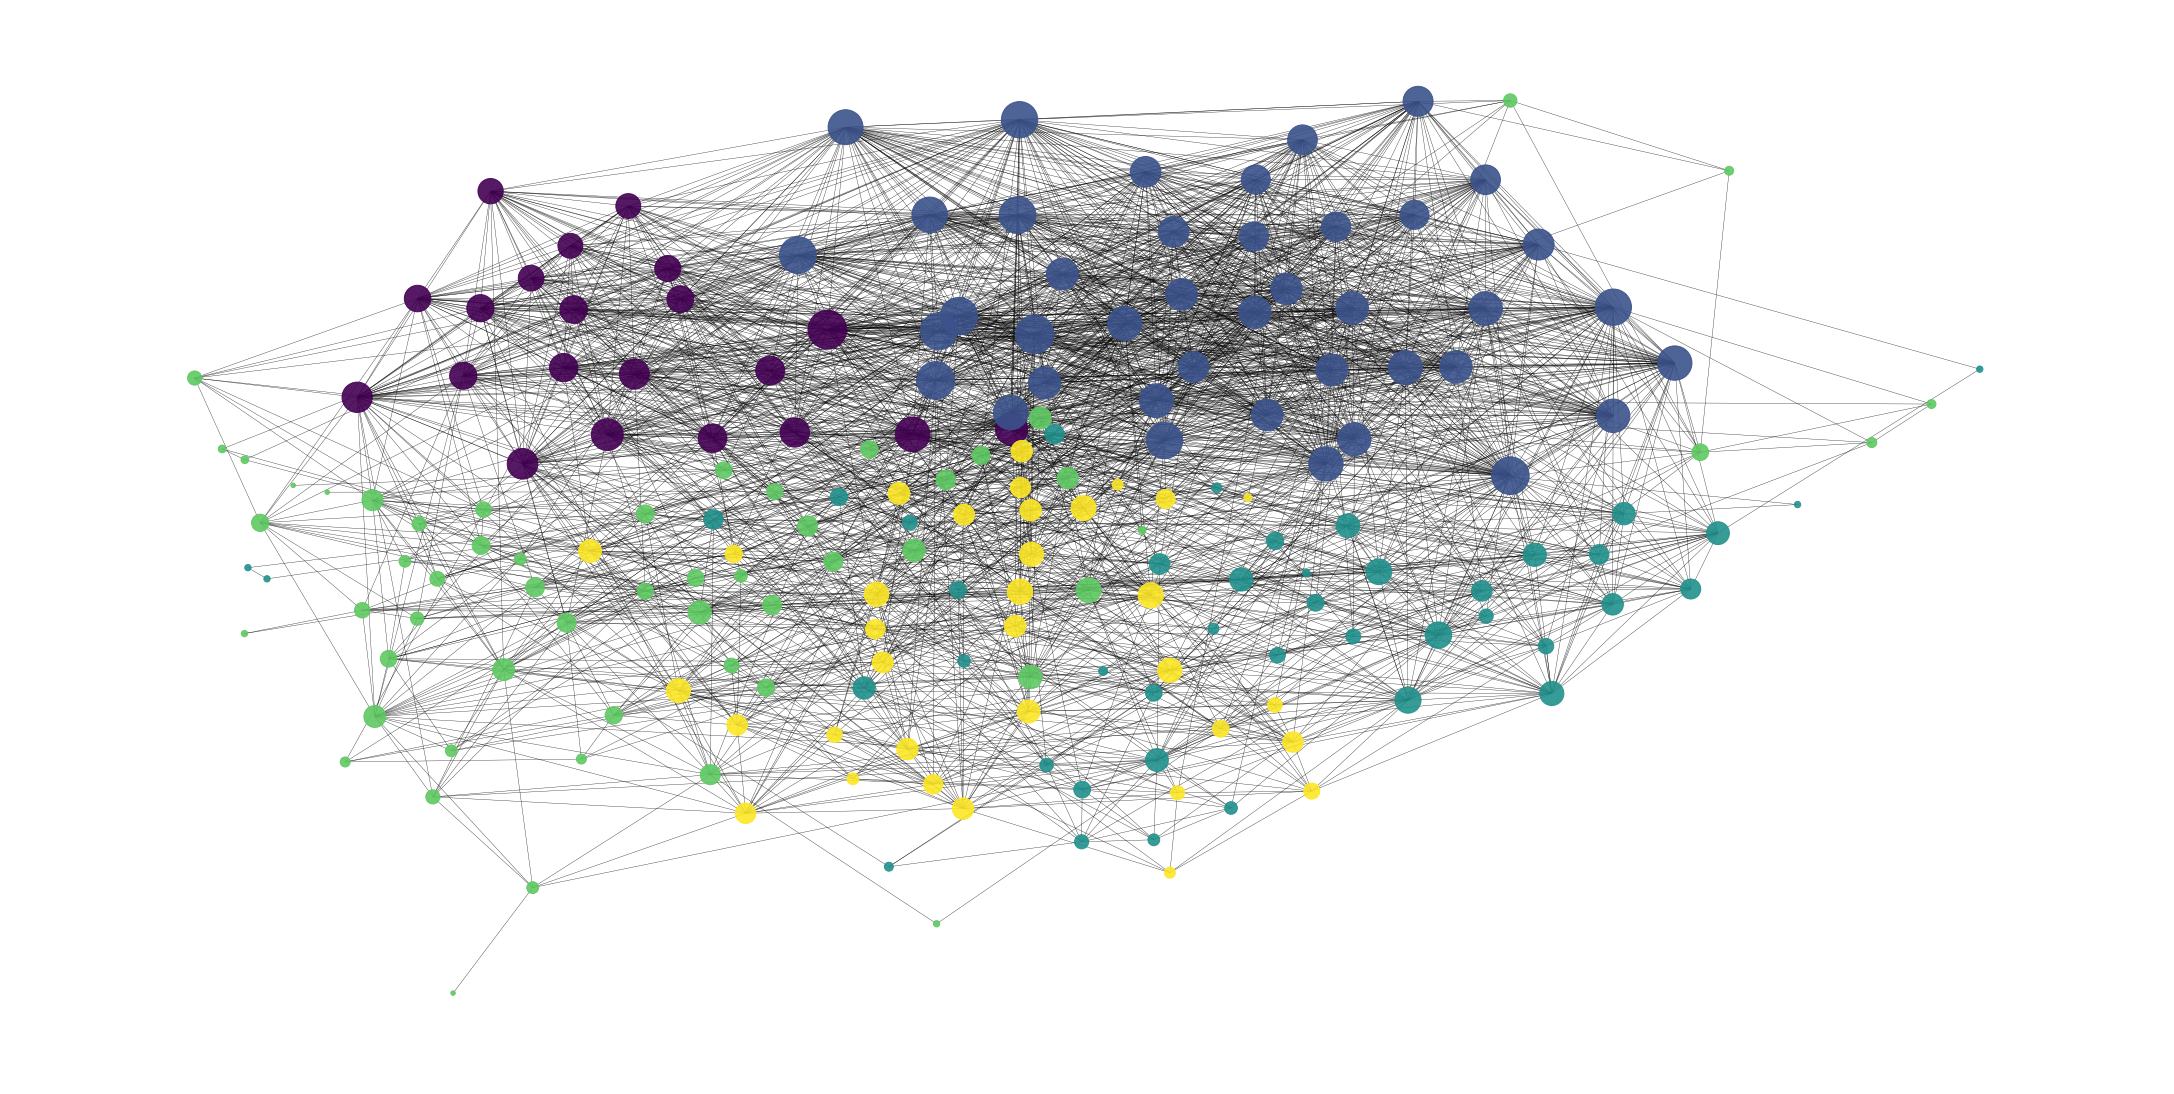

In [118]:
plt.figure(figsize=(30, 15))
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=2.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,

                        # Log
                        verbose=False)

positions = forceatlas2.forceatlas2_networkx_layout(un_Beatles_nw, pos=None, iterations=2000)
f = dict(nx.degree(un_Beatles_nw))
node_sizes = [v*20 for v in f.values()]
print("The distribution of the community sizes")
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw(un_Beatles_nw, positions, node_size=node_sizes, with_labels=False, width = 0.35, node_color=list(partition.values()), alpha=0.9)


In [119]:
# We compute the number of songs in every community
#communities_d stores the group of songs in the same community
communities_d=dict.fromkeys(list(range(0,len(np.unique(list(partition.values()))))))
for i in range(0,len(np.unique(list(partition.values())))):
    l=[]
    for el in partition:
        if partition[el]==i:
            l.append(el)
    communities_d[i]=l
    
size_communities=[len(x) for x in communities_d.values()]

size_communities #number of songs in each community

[21, 41, 43, 56, 34]

<font color='darkblue'> Next, we extract the **most common words** in each community. 
    
    
- <font color='darkblue'> First, counting the number of times a word appears in each song of the community. 

In [120]:
for idx in communities_d:
    community_words=[]
    for el in communities_d[idx]:
        el=el.replace(' ','-')
        path='lyrics_songs/'+el+'.txt'
        clean=clean_lyrics(path)
        for word in clean:
            community_words.append(word)
    print(FreqDist(community_words).most_common(5))


[('know', 185), ('say', 46), ('name', 41), ('hello', 33), ('love', 31)]
[('love', 295), ('know', 74), ('cant', 43), ('say', 43), ('see', 40)]
[('see', 82), ('girl', 76), ('little', 71), ('come', 52), ('ooh', 46)]
[('got', 90), ('baby', 76), ('home', 63), ('ive', 55), ('let', 55)]
[('yeah', 129), ('ill', 79), ('want', 69), ('well', 50), ('long', 44)]


- <font color='darkblue'> Second, counting in how many songs of the community a word appear.  Below, a function is created for that purpose. 

In [121]:
for idx in communities_d:
    community_words=[]
    for el in communities_d[idx]:
        el=el.replace(' ','-')
        path='lyrics_songs/'+el+'.txt'
        clean=clean_lyrics(path)
        unique=list(np.unique(clean))
        for word in unique:
            community_words.append(word)
    print('size:' ,size_communities[idx])
    print(FreqDist(community_words).most_common(5))

size: 21
[('know', 21), ('love', 6), ('like', 6), ('see', 6), ('things', 6)]
size: 41
[('love', 41), ('know', 25), ('see', 17), ('want', 15), ('never', 12)]
size: 43
[('see', 21), ('time', 17), ('like', 15), ('girl', 15), ('day', 13)]
size: 56
[('got', 19), ('know', 19), ('see', 16), ('time', 16), ('like', 16)]
size: 34
[('ill', 17), ('want', 15), ('know', 14), ('well', 13), ('like', 12)]


In [122]:
def community_words(community):
    community_words=[]
    for el in community:
        el=el.replace(' ','-')
        path='lyrics_songs/'+el+'.txt'
        clean=clean_lyrics(path)
        unique=list(np.unique(clean))
        for word in unique:
            community_words.append(word)
    return FreqDist(community_words).most_common(5)

community_words(communities_d[0])

[('know', 21), ('love', 6), ('like', 6), ('see', 6), ('things', 6)]

<font color='darkblue'> We were also interested in analyzing **in which community** the most famous songs belong.

In [123]:
def song_community(song):
    i=0
    for idx in communities_d:
        if song in communities_d[i]:
            return i
        i+=1
        
song_community('let it be')
community_words(communities_d[song_community('let it be')])

[('got', 19), ('know', 19), ('see', 16), ('time', 16), ('like', 16)]

###  <font color='darkblue'>Part 6: VADER Sentimental Analysis